# Reinforcement Learning 2025 - Final Assignment

**Authors:** Amit Ezer, Gal Yaacov Noy.

In [ ]:
!pip install minigrid gymnasium matplotlib

: 

In [82]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gymnasium as gym
import minigrid
from minigrid.wrappers import ImgObsWrapper, RGBImgPartialObsWrapper
from collections import deque

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [83]:
def preprocess(obs):
    """
    Convert RGB observation to tensor and normalize to [0,1] range.
    Input: RGB image array (H, W, 3)
    Output: tensor (C, H, W) normalized to [0,1]
    """
    return torch.tensor(obs, dtype=torch.float32).permute(2, 0, 1) / 255.0

def create_env(env_name):
    env = gym.make(env_name)
    env = RGBImgPartialObsWrapper(env)
    env = ImgObsWrapper(env)
    return env

In [108]:
class MiniGridCNN(nn.Module):
    def __init__(self, output_dim=128, input_channels=3, input_size=84):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Compute the output size after the conv layers by passing a dummy input.
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, input_size, input_size)
            conv_out_size = self.conv(dummy_input).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, output_dim),
            nn.ReLU()
        )
        
        self.output_dim = output_dim

    def forward(self, x):
        return self.fc(self.conv(x))

## DQN

In [85]:
class QNetwork(nn.Module):
    def __init__(self, num_actions, feature_dim=128, input_size=84):
        super().__init__()
        self.encoder = MiniGridCNN(output_dim=feature_dim, input_size=input_size)
        self.q_head = nn.Linear(feature_dim, num_actions)

    def forward(self, x):
        features = self.encoder(x)
        return self.q_head(features)

In [86]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.stack(states).to(device),
            torch.stack(actions).to(device),
            torch.stack(rewards).to(device),
            torch.stack(next_states).to(device),
            torch.stack(dones).to(device),
        )

    def __len__(self):
        return len(self.buffer)

In [87]:
def select_action(model, state, epsilon, num_actions):
    """
    Selects an action using an epsilon-greedy strategy:
    - With probability `epsilon`, a random action is chosen (exploration).
    - With probability `1 - epsilon`, the action with the highest Q-value is chosen (exploitation).
    """
    if random.random() < epsilon:
        return torch.tensor([random.randint(0, num_actions - 1)], device=device)
    with torch.no_grad():
        q_values = model(state.unsqueeze(0))
        return q_values.argmax(dim=1)

In [88]:
def train_double_dqn(
    env_name="MiniGrid-Dynamic-Obstacles-16x16-v0",
    num_episodes=5000,
    max_steps=500,
    batch_size=256,
    gamma=0.99,
    lr=1e-3,
    target_update_freq=100,
    replay_capacity=10_000,
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.995
):
    env = create_env(env_name)

    num_actions = env.action_space.n
    obs, _ = env.reset()
    input_size = obs.shape[0]

    # Models
    policy_net = QNetwork(num_actions, input_size=input_size).to(device)
    target_net = QNetwork(num_actions, input_size=input_size).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    replay_buffer = ReplayBuffer(capacity=replay_capacity)

    # Tracking
    episode_rewards = []
    episode_lengths = []
    losses = []
    epsilons = []
    global_step = 0
    epsilon = epsilon_start

    print(f"\n{'='*60}")
    print(f"TRAINING DOUBLE DQN ON {env_name.upper()}")
    print(f"{'='*60}")
    print(f"Episodes: {num_episodes} | Batch Size: {batch_size} | Learning Rate: {lr}")
    print(f"Gamma: {gamma} | Target Update: {target_update_freq} | Replay Capacity: {replay_capacity:,}")
    print(f"Epsilon: {epsilon_start} -> {epsilon_end} (decay: {epsilon_decay})")
    print(f"{'='*60}")

    for episode in range(num_episodes):
        obs, _ = env.reset()
        state = preprocess(obs).to(device)
        total_reward = 0
        steps = 0

        for _ in range(max_steps):
            action = select_action(policy_net, state, epsilon, num_actions)

            next_obs, reward, terminated, truncated, _ = env.step(action.item())
            next_state = preprocess(next_obs).to(device)
            done = terminated or truncated

            # Store transition
            transition = (
                state.cpu(),
                torch.tensor([action.item()], dtype=torch.long),
                torch.tensor([reward], dtype=torch.float32),
                next_state.cpu(),
                torch.tensor([done], dtype=torch.float32)
            )
            replay_buffer.push(transition)

            state = next_state
            total_reward += reward
            steps += 1
            global_step += 1

            # Train step
            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

                # Current Q-values for taken actions
                q_values = policy_net(states).gather(1, actions.view(-1, 1)).squeeze()

                with torch.no_grad():
                    # Double DQN: use policy network to select actions, target network to evaluate
                    next_actions = policy_net(next_states).argmax(dim=1, keepdim=True)
                    next_q_values = target_net(next_states).gather(1, next_actions).squeeze()
                    targets = rewards.squeeze() + gamma * next_q_values * (1 - dones.squeeze())

                loss = F.mse_loss(q_values, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.item())

            # Learn
            if global_step % target_update_freq == 0:
                target_net.load_state_dict(policy_net.state_dict())

            if done:
                break

        episode_rewards.append(total_reward)
        episode_lengths.append(steps)
        epsilons.append(epsilon)

        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        if episode % 100 == 0:
            recent_rewards = np.mean(episode_rewards[-50:]) if len(episode_rewards) >= 50 else np.mean(episode_rewards)
            recent_steps = np.mean(episode_lengths[-50:]) if len(episode_lengths) >= 50 else np.mean(episode_lengths)
            recent_loss = np.mean(losses[-100:]) if len(losses) >= 100 else (np.mean(losses) if losses else 0)
            print(f"[Double DQN] Ep {episode:4d} | Reward: {total_reward:6.2f} | Avg Reward: {recent_rewards:6.2f} | Steps: {steps:3d} | Avg Steps: {recent_steps:5.1f} | Epsilon: {epsilon:.3f} | Loss: {recent_loss:.4f}")

    env.close()

    print(f"\n{'='*60}")
    print(f"TRAINING COMPLETED!")
    print(f"Final Average Reward (last 100 episodes): {np.mean(episode_rewards[-100:]):.3f}")
    print(f"Final Average Steps (last 100 episodes): {np.mean(episode_lengths[-100:]):.1f}")
    print(f"Total Training Steps: {global_step:,}")
    print(f"{'='*60}")

    return {
        "name": "Double DQN",
        "rewards": episode_rewards,
        "steps": episode_lengths,
        "losses": losses,
        "epsilons": epsilons
    }


## REINFORCE

In [109]:
class ReinforcePolicy(nn.Module):
    def __init__(self, num_actions, input_size=84):
        super().__init__()
        self.encoder = MiniGridCNN(input_size=input_size)
        self.action_head = nn.Linear(self.encoder.output_dim, num_actions)

    def forward(self, x):
        features = self.encoder(x)
        logits = self.action_head(features)
        return torch.distributions.Categorical(logits=logits)

In [110]:
def compute_returns(rewards, gamma):
    """
    Compute discounted returns for a sequence of rewards.
    """
    returns = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns, dtype=torch.float32)
    
    # Normalize returns
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    
    return returns

In [111]:
def train_reinforce(
    env_name="MiniGrid-Dynamic-Obstacles-6x6-v0",
    num_episodes=1000,
    max_steps=500,
    gamma=0.99,
    lr=1e-3,
    entropy_coeff=0.01
):
    env = create_env(env_name)

    num_actions = env.action_space.n
    obs, _ = env.reset()

    policy = ReinforcePolicy(num_actions, input_size=obs.shape[0]).to(device)
    optimizer = optim.Adam(policy.parameters(), lr=lr)

    # Tracking
    episode_rewards = []
    episode_lengths = []
    losses = []

    print(f"\n{'='*60}")
    print(f"TRAINING REINFORCE ON {env_name.upper()}")
    print(f"{'='*60}")
    print(f"Episodes: {num_episodes} | Learning Rate: {lr} | Gamma: {gamma}")
    print(f"{'='*60}")

    for episode in range(num_episodes):
        obs, _ = env.reset()
        state = preprocess(obs).to(device)

        log_probs = []
        rewards = []
        entropies = []

        total_reward = 0
        steps = 0

        for _ in range(max_steps):
            dist = policy(state.unsqueeze(0))  # Add batch dimension
            action = dist.sample()
            log_prob = dist.log_prob(action)
            entropy = dist.entropy()

            next_obs, reward, terminated, truncated, _ = env.step(action.item())
            next_state = preprocess(next_obs).to(device)
            done = terminated or truncated

            log_probs.append(log_prob)
            entropies.append(entropy)
            rewards.append(reward)

            total_reward += reward
            state = next_state
            steps += 1

            if done:
                break

        returns = compute_returns(rewards, gamma).to(device)

        # Policy gradient loss
        log_probs = torch.stack(log_probs)
        entropies = torch.stack(entropies)
        loss = -(log_probs * returns).sum() - entropy_coeff * entropies.sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        episode_rewards.append(total_reward)
        episode_lengths.append(steps)
        losses.append(loss.item())

        if episode % 100 == 0:
            avg_reward = np.mean(episode_rewards[-50:]) if len(episode_rewards) >= 50 else np.mean(episode_rewards)
            avg_steps = np.mean(episode_lengths[-50:]) if len(episode_lengths) >= 50 else np.mean(episode_lengths)
            print(f"[REINFORCE] Ep {episode:4d} | Reward: {total_reward:6.2f} | Avg Reward: {avg_reward:6.2f} | Steps: {steps:3d} | Avg Steps: {avg_steps:5.1f} | Loss: {loss.item():.4f}")

    env.close()

    print(f"\n{'='*60}")
    print("TRAINING COMPLETED!")
    print(f"Final Avg Reward (last 100): {np.mean(episode_rewards[-100:]):.3f}")
    print(f"{'='*60}")

    return {
        "name": "REINFORCE",
        "rewards": episode_rewards,
        "steps": episode_lengths,
        "losses": losses
    }


In [92]:
def plot_training_results(logs, window=50, title="Double DQN Training Results"):
    """Plot training results with moving averages like in midterm."""
    def moving_average(data, window):
        if len(data) < window:
            return data
        return np.convolve(data, np.ones(window)/window, mode='valid')

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(title, fontsize=16, fontweight='bold')

    # Episode Rewards
    axes[0, 0].plot(logs["rewards"], alpha=0.3, label="Raw", color='blue')
    if len(logs["rewards"]) >= window:
        smooth_rewards = moving_average(logs["rewards"], window)
        axes[0, 0].plot(range(window-1, len(logs["rewards"])), smooth_rewards,
                       label=f"Moving Avg ({window})", linewidth=2, color='red')
    axes[0, 0].set_title("Episode Rewards")
    axes[0, 0].set_xlabel("Episode")
    axes[0, 0].set_ylabel("Reward")
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)

    # Episode Steps
    axes[0, 1].plot(logs["steps"], alpha=0.3, label="Raw", color='green')
    if len(logs["steps"]) >= window:
        smooth_steps = moving_average(logs["steps"], window)
        axes[0, 1].plot(range(window-1, len(logs["steps"])), smooth_steps,
                       label=f"Moving Avg ({window})", linewidth=2, color='orange')
    axes[0, 1].set_title("Episode Length")
    axes[0, 1].set_xlabel("Episode")
    axes[0, 1].set_ylabel("Steps")
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)

    # Training Loss
    if logs["losses"]:
        axes[1, 0].plot(logs["losses"], alpha=0.6, color='purple')
        if len(logs["losses"]) >= window:
            smooth_loss = moving_average(logs["losses"], window)
            axes[1, 0].plot(range(window-1, len(logs["losses"])), smooth_loss,
                           label=f"Moving Avg ({window})", linewidth=2, color='red')
            axes[1, 0].legend()
    axes[1, 0].set_title("Training Loss")
    axes[1, 0].set_xlabel("Training Step")
    axes[1, 0].set_ylabel("TD Loss")
    axes[1, 0].grid(alpha=0.3)

    # Epsilon Decay
    axes[1, 1].plot(logs["epsilons"], color='brown', linewidth=2)
    axes[1, 1].set_title("Exploration Rate (Epsilon)")
    axes[1, 1].set_xlabel("Episode")
    axes[1, 1].set_ylabel("Epsilon")
    axes[1, 1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

def print_performance_summary(logs):
    """Print performance summary like in midterm."""
    print(f"\n{'='*60}")
    print(f"PERFORMANCE SUMMARY - {logs['name'].upper()}")
    print(f"{'='*60}")

    final_rewards = np.mean(logs["rewards"][-100:]) if len(logs["rewards"]) >= 100 else np.mean(logs["rewards"])
    best_rewards = max([np.mean(logs["rewards"][i:i+100]) for i in range(len(logs["rewards"])-99)]) if len(logs["rewards"]) >= 100 else max(logs["rewards"])
    final_steps = np.mean(logs["steps"][-100:]) if len(logs["steps"]) >= 100 else np.mean(logs["steps"])
    final_loss = np.mean(logs["losses"][-1000:]) if len(logs["losses"]) >= 1000 else (np.mean(logs["losses"]) if logs["losses"] else 0)

    print(f"Final Performance (last 100 episodes):")
    print(f"  Average Reward: {final_rewards:.3f}")
    print(f"  Average Steps: {final_steps:.1f}")
    print(f"  Training Loss: {final_loss:.4f}")
    print(f"\nBest Performance:")
    print(f"  Best 100-episode Average Reward: {best_rewards:.3f}")
    print(f"  Total Episodes: {len(logs['rewards'])}")
    print(f"  Total Training Steps: {len(logs['losses']):,}")
    print(f"{'='*60}")

EXPERIMENTS = {
    'Double DQN': train_double_dqn,
    'REINFORCE': train_reinforce,
    # 'PPO': train_ppo
}

def run_experiment(name, **kwargs):
    """Run complete experiment: train agent, analyze, and plot."""
    # Train agent
    logs = EXPERIMENTS[name](**kwargs)

    # Analyze and visualize
    print_performance_summary(logs)
    plot_training_results(logs)

    return logs


TRAINING DOUBLE DQN ON MINIGRID-DYNAMIC-OBSTACLES-6X6-V0
Episodes: 1000 | Batch Size: 64 | Learning Rate: 0.001
Gamma: 0.99 | Target Update: 100 | Replay Capacity: 10,000
Epsilon: 1.0 -> 0.01 (decay: 0.995)
[Double DQN] Ep    0 | Reward:  -1.00 | Avg Reward:  -1.00 | Steps:   3 | Avg Steps:   3.0 | Epsilon: 0.995 | Loss: 0.0000
[Double DQN] Ep  100 | Reward:  -1.00 | Avg Reward:  -1.00 | Steps:  32 | Avg Steps:   9.3 | Epsilon: 0.603 | Loss: 0.0002
[Double DQN] Ep  200 | Reward:  -1.00 | Avg Reward:  -0.96 | Steps:   4 | Avg Steps:  11.3 | Epsilon: 0.365 | Loss: 0.0013
[Double DQN] Ep  300 | Reward:  -1.00 | Avg Reward:  -0.83 | Steps:  35 | Avg Steps:  21.9 | Epsilon: 0.221 | Loss: 0.0016
[Double DQN] Ep  400 | Reward:  -1.00 | Avg Reward:  -0.06 | Steps:  15 | Avg Steps:  16.8 | Epsilon: 0.134 | Loss: 0.0032
[Double DQN] Ep  500 | Reward:   0.89 | Avg Reward:   0.39 | Steps:  18 | Avg Steps:  21.3 | Epsilon: 0.081 | Loss: 0.0005
[Double DQN] Ep  600 | Reward:   0.87 | Avg Reward:   

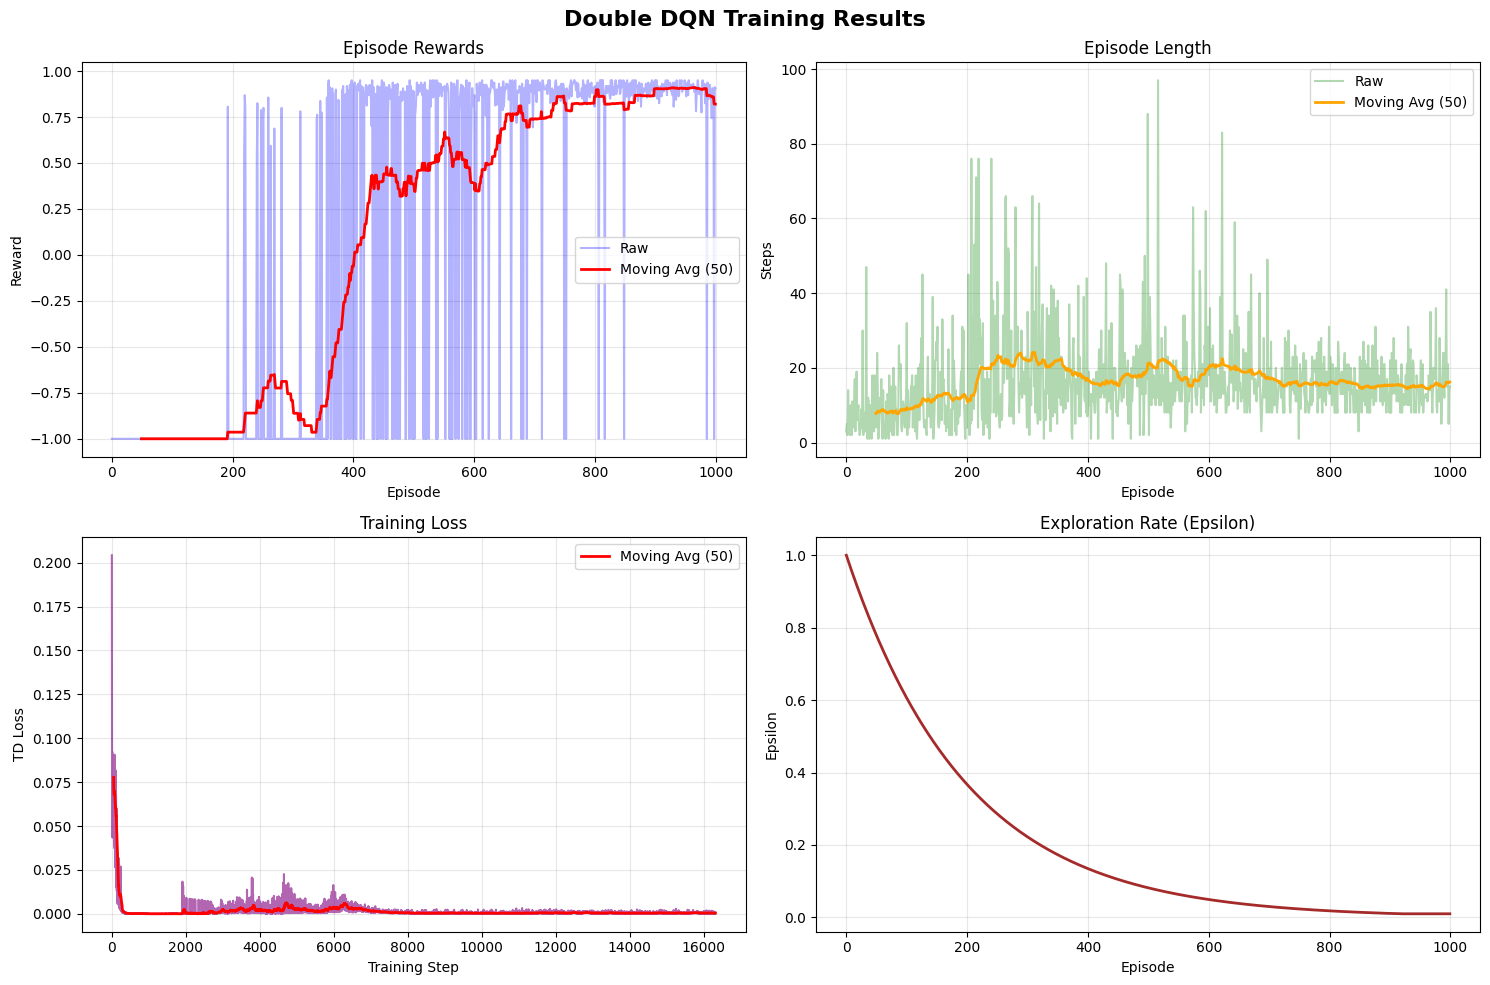

In [94]:
dqn_logs = run_experiment('Double DQN', env_name="MiniGrid-Dynamic-Obstacles-6x6-v0", num_episodes=1000, max_steps=100, batch_size=64)

In [112]:
test_reinforce_logs = run_experiment('REINFORCE', env_name="MiniGrid-Dynamic-Obstacles-6x6-v0", num_episodes=1000, max_steps=100)


TRAINING REINFORCE ON MINIGRID-DYNAMIC-OBSTACLES-6X6-V0
Episodes: 1000 | Learning Rate: 0.001 | Gamma: 0.99
[REINFORCE] Ep    0 | Reward:  -1.00 | Avg Reward:  -1.00 | Steps:  15 | Avg Steps:  15.0 | Loss: -0.1650


/tmp/ipykernel_217537/2054915064.py:13: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  returns = (returns - returns.mean()) / (returns.std() + 1e-8)


ValueError: Expected parameter logits (Tensor of shape (1, 3)) of distribution Categorical(logits: torch.Size([1, 3])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[nan, nan, nan]], device='cuda:0', grad_fn=<SubBackward0>)